In [1]:
import itertools
import gc
from bib import *
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import backend as K 
from keras import  activations
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Dense, Activation, regularizers,BatchNormalization,Dropout
import tensorflow as tf
from  tqdm import tqdm_notebook
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [2]:
eps=np.finfo(np.float32).eps
xtrains,ytrains,xvals,yvals,xtest,ytest=split(('CHL 1','THERM 1','SSH','SR','WS'),
                                               ['CHL '+ str(i) for i in range(2,19)])
ytrains,yvals,ytest=applyToy(lambda x:np.log(x)/np.log(10),ytrains,yvals,ytest)

In [8]:
def custom_activation(x):
    return K.exp( x * np.log(10)+eps)+eps
get_custom_objects().update({'custom_activation': Activation(custom_activation)})
def generate(arch,act):
    layers=[]
    for index,size in enumerate(arch):
        if index ==0:
            layers.append(Dense(size, input_shape=(5,),activation=act[index]))
#             layers.append(BatchNormalization())

        else:
            layers.append(Dense(size,activation=act[index]))
#             layers.append(Dropout(0.3))
    layers.append(Dense(17,activation='linear',kernel_regularizer=regularizers.l2(0.01)))
    model = Sequential(layers)
    model.compile(optimizer='Adam',
              loss='mse')
    return model
callbacks = [EarlyStopping(monitor='val_loss', patience=150)]

In [9]:
def validate(arch,act,xtrains,ytrains,xvals,yvals):
    fold_evaluation=[]
    for xt,yt,xv,yv in tqdm_notebook(zip(xtrains,ytrains,xvals,yvals),total=len(xtrains)):
        model=generate(arch,act)
        
        mean=xt.mean()
        std=xt.std()
        
        xt=(xt-mean)/std
        xv=(xv-mean)/std
        
        
#         yt=np.exp(yt*np.log(10))-eps
#         yv=np.exp(yv*np.log(10))-eps
        
        
        model.fit(xt.values,yt.values,
                  epochs=10000,
                  callbacks=callbacks,
                  verbose=0,
                  batch_size=73*10, 
                  validation_data=(xv.values,yv.values))
        
        yp = model.predict(xv.values)
        
        #check error in original space
        
        yp=np.exp(yp*np.log(10))
        yv=np.exp(yv*np.log(10))       
        fold_evaluation.append(evaluate(yp,yv))
        print(evaluate(yp,yv))
        
    return np.mean(fold_evaluation),np.std(fold_evaluation )


In [10]:
arch=(1000, 500, 500, 500, 1000, 2000)
K.clear_session()
print('ARCH :'+ str(arch))
# print('ACT :'+ str(act))
error,std=validate(arch,['softplus']*len(arch),xtrains,ytrains,xvals,yvals)
print('\t error: %.5f +- %.5f' % (error,std))

ARCH :(1000, 500, 500, 500, 1000, 2000)
0.054461514231893854
0.06358607821445475
0.05004979180040508
0.1103819066752673
0.09309208452187204
0.06278859718571346
0.050315658891204366
0.06503107061840024
0.048213383290999084
0.04194716527085001
0.036845526828659936
0.055128335498225586
0.04370039625779365
0.05045461207255122
0.05286788811300569
0.04933471890722512
	 error: 0.05801 +- 0.01835


stock p 5:
ARCH :(100, 50, 50, 200)
	 error: 0.06484 +- 0.01960
l2 reg 0.01 p5
ARCH :(100, 50, 50, 200)
	 error: 0.11383 +- 0.01972
l2 reg 0.01 p15:
ARCH :(100, 50, 50, 200)
	 error: 0.11171 +- 0.02045
l1 reg 0.01
ARCH :(100, 50, 50, 200)
	 error: 0.16010 +- 0.01883
batchnorm
ARCH :(100, 50, 50, 200)
	 error: 0.06487 +- 0.01954
dropout 0.5 +bn
ARCH :(100, 50, 50, 200)
	 error: 0.07713 +- 0.02090
10x dropout 0.5 +bn
ARCH :(1000, 500, 500, 2000)
    error: 0.06316 +- 0.02064
10x dropout 0.1 +bn
ARCH :(1000, 500, 500, 2000)
    error: 0.06272 +- 0.01884
droput 0.3:
ARCH :(1000, 2000, 2000, 2000)
    error: 0.06066 +- 0.02155
    
10x+ stock p 15:
ARCH :(1000, 500, 1000, 2000)
    error: 0.05996 +- 0.02092
ARCH :(1000, 500, 500, 1000, 2000, 2000)
	 error: 0.06020 +- 0.02042    
ARCH :(1000, 1000, 2000, 2000)
    error: 0.06035 +- 0.02012
ARCH :(1000, 500, 1000, 1000, 1000, 2000)
	 error: 0.06070 +- 0.02034
ARCH :(1000, 500, 500, 500, 1000, 2000)
	 error: 0.05959 +- 0.01974
ARCH :(1000, 500, 500, 500, 500, 1000, 2000)
	 error: 0.06135 +- 0.02048
ARCH :(1000, 500, 500, 1000, 1000, 2000)
	 error: 0.05913 +- 0.01918
ARCH :(1000, 500, 500, 1000, 1000, 2000)
	 error: 0.06173 +- 0.01997
ARCH :(1000, 500, 500, 1000, 1000, 2000)
	 error: 0.06152 +- 0.01935
ARCH :(1000, 500, 500, 500, 1000, 2000)
	 error: 0.06073 +- 0.02006
ARCH :(1000, 500, 500, 500, 1000, 2000)
	 error: 0.05953 +- 0.02005
ARCH :(1000, 500, 500, 500, 1000, 2000)
     error: 0.05876 +- 0.01994

custom act + relu:
ARCH :(1000, 500, 500, 500, 1000, 2000)
	 error: 0.06847 +- 0.02292
relu + custom act + relu:
ARCH :(1000, 500, 500, 500, 1000, 2000)
     error: 0.08397 +- 0.03275
relu + custom act +eps:
ARCH :(1000, 500, 500, 500, 1000, 2000)     
	 error: 0.06192 +- 0.01834

elu +elu no norm
ARCH :(1000, 500, 500, 500, 1000, 2000)     
     	 error: 0.06278 +- 0.01850
elu +lin no norm
         error: 0.06157 +- 0.01891
elu +lin  norm      
         error: 0.06379 +- 0.02247
         
gauss norm:
ARCH :(1000, 500, 500, 500, 1000, 2000)
error: 0.06018 +- 0.01965

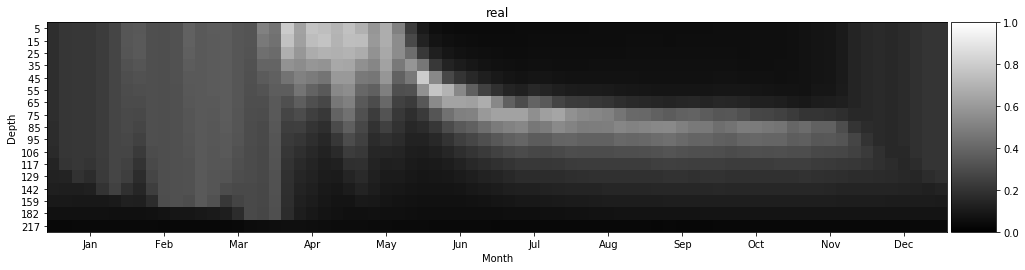

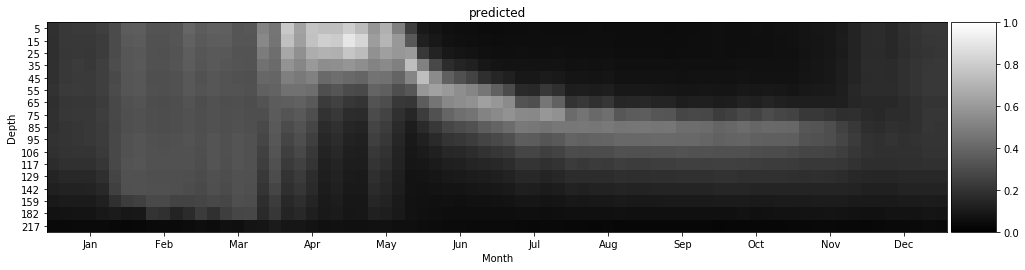

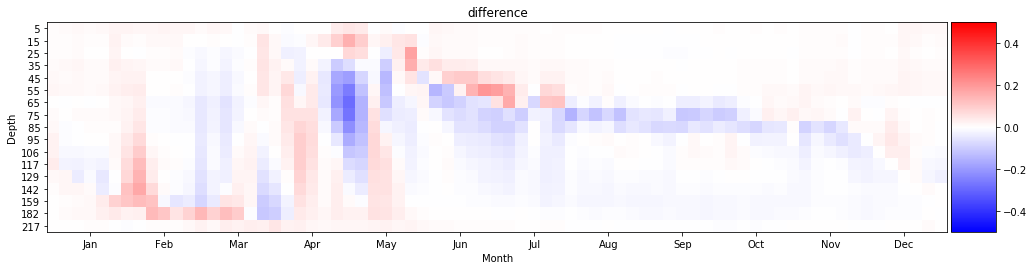

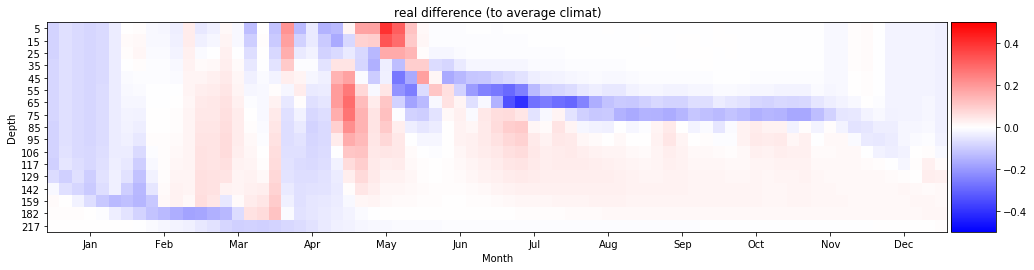

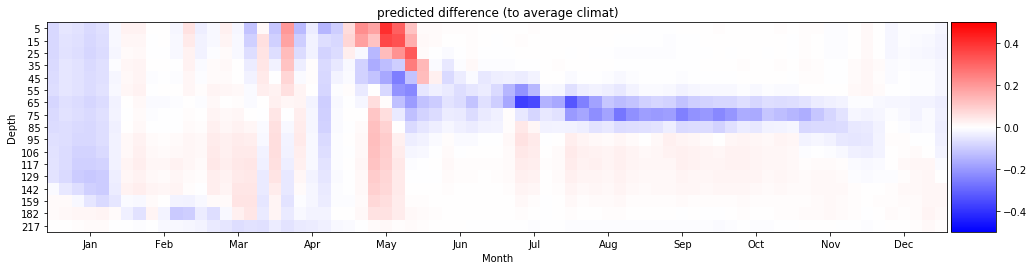

In [5]:
model=generate((1000, 500, 500, 500, 1000, 2000),['softplus']*6)
mean=xtrains[0].mean()
std=xtrains[0].std()

xt=(xtrains[0]-mean)/std
xv=(xvals[0]-mean)/std

model.fit(xt.values,ytrains[0].values,
          epochs=10000,
          callbacks=callbacks,
          verbose=0,
          batch_size=73*10, 
          validation_data=(xv.values,yvals[0].values))
xt=(xtest-mean)/std
yp = model.predict(xt.values)


yp=np.exp(yp*np.log(10))
yt=np.exp(ytest*np.log(10)).values


plotYear(yt,title='real')
plotYear(yp,title='predicted')
plotYear(yp-yt,title='difference',c='bwr',d=True)
climato(yt,title='real difference (to average climat)')
climato(yp,title='predicted difference (to average climat)')